In [1]:
import sqlite3
import time

In [5]:
from matplotlib import pyplot as plt

In [7]:
DB_FILE = "/Users/kyunghyuncho/Downloads/pubmed_data.db"

In [8]:
# Case 1: read using offset and limit
def read_using_offset_limit(chunk_size=10, total_size=1_000_000):
    conn = sqlite3.connect(DB_FILE)
    cursor = conn.cursor()

    elapsed_time = []
    
    for offset in range(0, total_size, chunk_size):
        start_time = time.time()
        batch = []
        cursor.execute("SELECT * FROM articles LIMIT ? OFFSET ?", (chunk_size, offset))
        rows = cursor.fetchall()
        for row in rows:
            batch.append(row)
        end_time = time.time()
        elapsed_time.append(end_time - start_time)

    conn.close()

    return elapsed_time

In [19]:
# Case 1a: read using offset and limit with rowid
# based on https://stackoverflow.com/questions/12266025/sqlite-query-optimization-using-limit-and-offset/49651023#49651023
def read_using_offset_limi_rowid(chunk_size=10, total_size=1_000_000):
    conn = sqlite3.connect(DB_FILE)
    cursor = conn.cursor()

    elapsed_time = []
    
    for offset in range(0, total_size, chunk_size):
        start_time = time.time()
        batch = []
        cursor.execute("SELECT * FROM articles WHERE rowid in ("
                       "SELECT rowid FROM articles LIMIT ? OFFSET ?)", (chunk_size, offset))
        rows = cursor.fetchall()
        for row in rows:
            batch.append(row)
        end_time = time.time()
        elapsed_time.append(end_time - start_time)

    conn.close()

    return elapsed_time

In [9]:
# Case 2: read using fetchmany
def read_using_fetchmany(chunk_size=10, total_size=1_000_000):
    conn = sqlite3.connect(DB_FILE)
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM articles")
        
    elapsed_time = []
    
    for offset in range(0, total_size, chunk_size):
        start_time = time.time()
        batch = []
        
        rows = cursor.fetchmany(chunk_size)
        for row in rows:
            batch.append(row)
        
        end_time = time.time()
        elapsed_time.append(end_time - start_time)

    conn.close()

    return elapsed_time

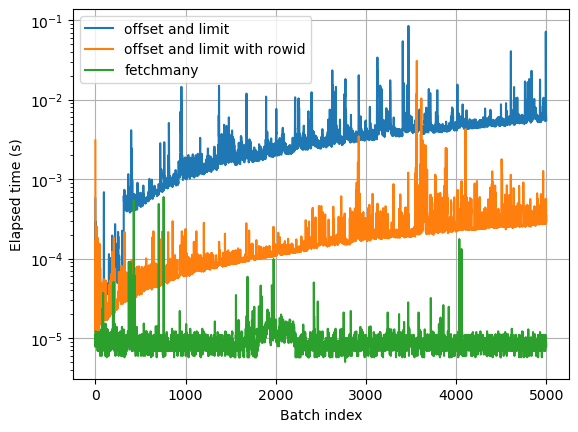

In [20]:
# try all cases and plot the `elapsed_time` for batches.
# use log y-scale.
elapsed_time_offset_limit = read_using_offset_limit(total_size=50_000)
elapsed_time_offset_limit_rowid = read_using_offset_limi_rowid(total_size=50_000)
elapsed_time_fetchmany = read_using_fetchmany(total_size=50_000)

plt.plot(elapsed_time_offset_limit, label="offset and limit")
plt.plot(elapsed_time_offset_limit_rowid, label="offset and limit with rowid")
plt.plot(elapsed_time_fetchmany, label="fetchmany")
plt.legend()

plt.yscale("log")

plt.xlabel("Batch index")
plt.ylabel("Elapsed time (s)")
plt.grid(True)
plt.show()